In [11]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DATA CLEANING & PREP
# --- LOAD DATA ---
df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
# --- DATA CLEANING ---
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# --- PHASE 1: ABC ANALYSIS (Product Revenue) ---
# Calculating total revenue per product
product_revenue = df.groupby('Description')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
product_revenue['CumRevenue'] = product_revenue['TotalPrice'].cumsum()
total_rev = product_revenue['TotalPrice'].sum()
product_revenue['CumPercent'] = (product_revenue['CumRevenue'] / total_rev) * 100

In [12]:
# --- PHASE 1: ABC ANALYSIS (Revenue Contribution) ---
# Calculating cumulative revenue percentage
product_revenue = df.groupby('Description')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False)
product_revenue['CumRevenue'] = product_revenue['TotalPrice'].cumsum()
total_rev = product_revenue['TotalPrice'].sum()
product_revenue['CumPercent'] = (product_revenue['CumRevenue'] / total_rev) * 100

# Classify products into A, B, C categories
def abc_classify(p):
    if p <= 80: return 'A (Top 80%)'
    elif p <= 95: return 'B (Next 15%)'
    else: return 'C (Bottom 5%)'

product_revenue['ABC_Category'] = product_revenue['CumPercent'].apply(abc_classify)

In [13]:
# --- PHASE 2: COHORT ANALYSIS (Retention) ---
# Helper function to get the first day of the month
def get_month(x): return dt.datetime(x.year, x.month, 1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

def get_date_int(df, column):
    return df[column].dt.year, df[column].dt.month

# Calculating cohort index (months since first purchase)
inv_y, inv_m = get_date_int(df, 'InvoiceMonth')
coh_y, coh_m = get_date_int(df, 'CohortMonth')
df['CohortIndex'] = (inv_y - coh_y) * 12 + (inv_m - coh_m) + 1

# Count unique customers per cohort and month
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Creating cohort table
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Calculating retention rate
retention = cohort_counts.divide(cohort_counts.iloc[:,0], axis=0)

# Keeping first 6 months only (cleaner view)
retention = retention.iloc[:, :6]
retention.index = retention.index.strftime('%Y-%m')

In [15]:
# --- PHASE 3: MARKET BASKET ANALYSIS ---
target_item = 'WHITE HANGING HEART T-LIGHT HOLDER'

# Finding invoices containing the target item
target_invoices = df[df['Description'] == target_item]['InvoiceNo'].unique()

# Finding what ELSE was in those same invoices
basket_suggestions = df[df['InvoiceNo'].isin(target_invoices) & (df['Description'] != target_item)]
top_suggestions = basket_suggestions.groupby('Description')['InvoiceNo'].nunique().sort_values(ascending=False)

# Count how often each product appears
top_cross_sell = (
    basket_suggestions.groupby('Description')['InvoiceNo']
    .nunique()
    .sort_values(ascending=False)
)

Text(0.5, 1.0, 'Product Count by ABC Category')

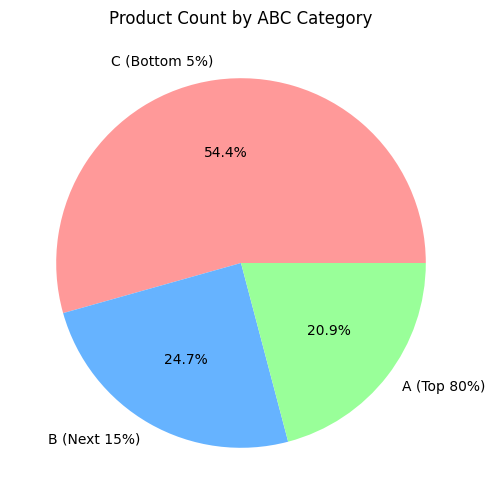

In [16]:
# --- VISUALIZATION ---
plt.figure(figsize=(16, 6))

# Subplot 1: ABC Analysis
plt.subplot(1, 2, 1)
abc_counts = product_revenue['ABC_Category'].value_counts()
plt.pie(abc_counts, labels=abc_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Product Count by ABC Category')


Top Recommendation for 'WHITE HANGING HEART T-LIGHT HOLDER':
Description
RED HANGING HEART T-LIGHT HOLDER    455
Name: InvoiceNo, dtype: int64


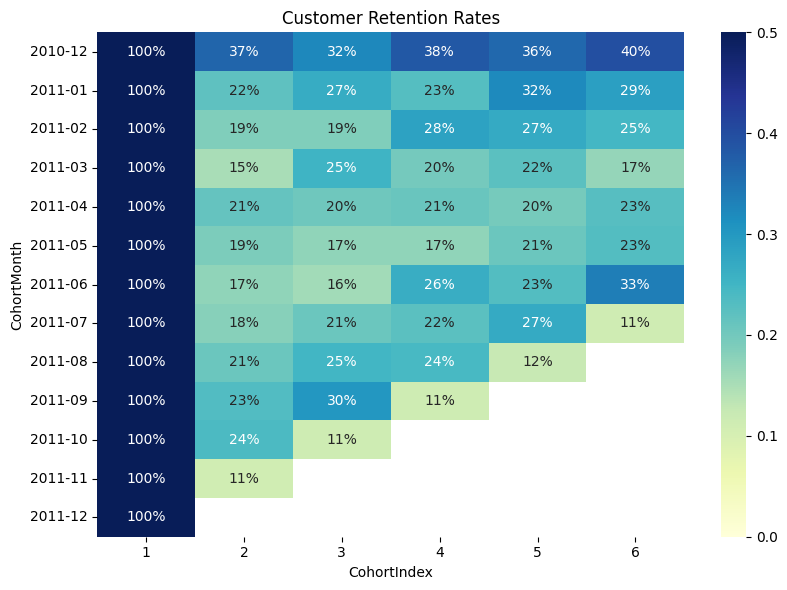

In [21]:
plt.figure(figsize=(16, 6))

# Subplot 2: Cohort Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmin=0.0, vmax=0.5)
plt.title('Customer Retention Rates')
plt.tight_layout()
plt.savefig('retail_analytics_dashboard.png')

print(f"Top Recommendation for '{target_item}':")
print(top_suggestions.head(1))

In [19]:
# --- 8. OUTPUT KEY INSIGHT ---
print(f"Top cross-sell product for '{target_item}':")
print(top_cross_sell.head(1))

Top cross-sell product for 'WHITE HANGING HEART T-LIGHT HOLDER':
Description
RED HANGING HEART T-LIGHT HOLDER    455
Name: InvoiceNo, dtype: int64
